# Hypedsearch testing

The goal of this notebook is to analyze the latest run of Hypedsearch

## Imports and Base Data

In [11]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import yaml
import os
import glob

from hypedsearch.src.preprocessing import load_spectra

path_to_config = "conf/config.yaml"
with open(path_to_config, 'rb') as f:
    conf = yaml.safe_load(f.read())

spectra_dir = conf['spectra_dir']
database_file = conf['database_file']
output_dir = conf['output_dir']
ppm_tol = conf['ppm_tolerance']

## Tests

### 1. How many spectra did Comet identify and how many did Hypedsearch?

In [2]:
def get_comet_results(results_dir):
    count, prev_id = 0, -1
    natives, hybrids = [], []
    native_ids, hybrid_ids = [], []
    native_parents, hybrid_parents = [], []
    
    for file in glob.glob(results_dir + "/*txt"):
        with open(file, 'r') as c:
            next(c)
            next(c)
            for line in c:
                A = line.split("\t")
                spec_id = A[0]
                if spec_id != prev_id:
                    prev_id = spec_id
                    count = count + 1 #Counts number of id' spectra
                parent = A[15]
                seq = A[11]
                if "Hybrid" not in parent:
                    natives.append(seq)
                    native_ids.append(int(spec_id))
                    native_parents.append(parent)
                else:
                    hybrids.append(seq)
                    hybrid_ids.append(int(spec_id))
                    hybrid_parents.append(parent)
                    
    return natives, hybrids, count, native_ids, hybrid_ids, native_parents, hybrid_parents

def get_hypedsearch_results(results_dir):
    count, prev_id = 0, -1
    natives, hybrids = [], []
    native_ids, hybrid_ids = [], []
    
    for file in glob.glob(results_dir + "/*txt"):
        with open(file, 'r') as h:
            for line in h:
                A = line.split("\t")
                spec_id = A[0]
                if spec_id != prev_id:
                    prev_id = spec_id
                    count = count + 1
                hybrid_data = A[1]
                seq = A[2]
                if hybrid_data == "Hybrid":
                    hybrids.append(seq.replace("-",""))
                    hybrid_ids.append(int(spec_id))
                else:
                    natives.append(seq)
                    native_ids.append(int(spec_id))
                
    return natives, hybrids, count, native_ids, hybrid_ids

def intersection(lst1, lst2):
    lst3 = []
    for i, value in enumerate(lst1):
        if value in lst2:
            lst3.append(value)
            
    return lst3

Text(0.5, 1.0, 'Number of spectra identified for Comet and Hypedsearch')

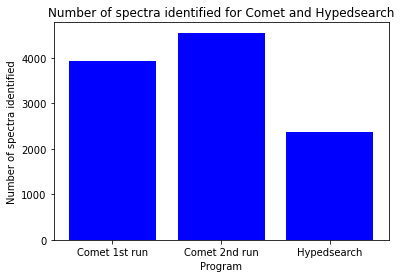

In [3]:
first_run_results = os.path.join(output_dir, 'comet_run_1')
second_run_results = os.path.join(output_dir, 'comet_run_2')
first_run_hypedsearch_results = os.path.join(output_dir, 'Hypedsearch_outputs')
_, _, id_count, native_ids, hybrid_ids, _, _ = get_comet_results(first_run_results)
_, _, hyp_id_count, hs_native_ids, hs_hybrid_ids = get_hypedsearch_results(first_run_hypedsearch_results)
_, _, id_count2, native_ids2, hybrid_ids2, _, _ = get_comet_results(second_run_results)

plt.bar(["Comet 1st run", "Comet 2nd run", "Hypedsearch"], [id_count, id_count2, hyp_id_count], color = "blue")
plt.xlabel("Program")
plt.ylabel("Number of spectra identified")
plt.title("Number of spectra identified for Comet and Hypedsearch")


### 2. Out of the spectra Comet identified, did Hypedsearch identify them as well? Out of the spectra Hypedsearch identified, did Comet identify them as well?

Venn diagram for natives and hybrids

Q: Are the green things novel natives? How often are these things the top scoring native?

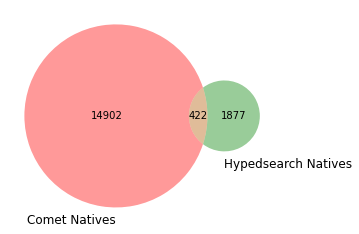

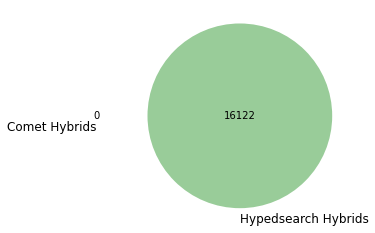

In [4]:
comet_natives, comet_hybrids, id_count, native_ids, hybrid_ids, native_parents, hybrid_parents = get_comet_results(first_run_results)
hypedsearch_natives, hypedsearch_hybrids, hyp_id_count, hs_native_ids, hs_hybrid_ids = get_hypedsearch_results(first_run_hypedsearch_results)
native_intersection = intersection(comet_natives, hypedsearch_natives)
hybrid_intersection = intersection(comet_hybrids, hypedsearch_hybrids)


native_venn = venn2(subsets = (len(comet_natives), len(hypedsearch_natives), len(native_intersection)), set_labels= ("Comet Natives", "Hypedsearch Natives"))
plt.show()
hybrid_venn = venn2(subsets = (len(comet_hybrids), len(hypedsearch_hybrids), len(hybrid_intersection)), set_labels= ("Comet Hybrids", "Hypedsearch Hybrids"))
plt.show()

### 3. What about on the second time Comet ran?

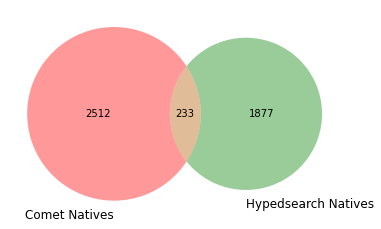

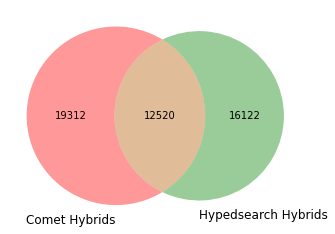

In [5]:
comet_natives, comet_hybrids, id_count, native_ids2, hybrid_ids2, native_parents2, hybrid_parents2 = get_comet_results(second_run_results)
native_intersection = intersection(comet_natives, hypedsearch_natives)
hybrid_intersection = intersection(comet_hybrids, hypedsearch_hybrids)

native_venn = venn2(subsets = (len(comet_natives), len(hypedsearch_natives), len(native_intersection)), set_labels= ("Comet Natives", "Hypedsearch Natives"))
plt.show()
hybrid_venn = venn2(subsets = (len(comet_hybrids), len(hypedsearch_hybrids), len(hybrid_intersection)), set_labels= ("Comet Hybrids", "Hypedsearch Hybrids"))
plt.show()

### For Comet Hybrids not found in Hypedsearch, are they decoys?

Q: How many things in red are decoys?

Q: How many things in green correspond to Comet hybrids?

Q: How many things in green are not the top scoring Hypedsearch hybrid?

In [6]:
def get_decoys(filepath):
    decoy_list = []
    for file in glob.glob(filepath + "/*txt"):
        with open(file, 'r') as c:
                next(c)
                next(c)
                for line in c:
                    A = line.split("\t")
                    parent_prot = A[15]
                    seq = A[11]
                    if "DECOY" in parent_prot:
                        decoy_list.append(seq)
        
    return decoy_list, set(decoy_list)

def check_for_mouse(protein_list):
    for protein in protein_list:
        if "Hypedsearch" not in protein:
            return True
    
    return False

def check_subsequence(hybrid, parent_set):
    # want to check whether this hybrid is a subsequence of either side of any parent
    
    for parent in parent_set:
        target_seq = parent.split("_")[-1]
        left_parent, right_parent = target_seq.split("-")
        if hybrid in left_parent or hybrid in right_parent:
            return True
    
    return False

In [7]:
decoy_hybrids, interesting_hybrids = [], []
for i, hybrid in enumerate(comet_hybrids):
    if hybrid not in hybrid_intersection:
        scan_num = hybrid_ids2[i]
        parent = hybrid_parents2[i]
        if "DECOY" in parent:
            decoy_hybrids.append((hybrid, scan_num, parent))
        else:
            interesting_hybrids.append((hybrid, scan_num, parent))

print(len(decoy_hybrids), len(interesting_hybrids), len(comet_hybrids) - len(hybrid_intersection), len(intersection(decoy_hybrids, interesting_hybrids)))

3395 3397 6792 0


In [8]:
# Now to look into interesting hybrids

# Want to see if these are actually natives. I.e, if we take out the natives, what's left?

current_natives, very_interesting_hybrids = [], []
for hybrid, scan_num, parent in interesting_hybrids:
    parent_list = parent.split(",")
    if check_for_mouse(parent_list):
        current_natives.append(hybrid)
    else:
        parent_set = set(parent_list)
        
        if check_subsequence(hybrid, parent_set):
            current_natives.append((hybrid, scan_num, parent))
        
        else:
            very_interesting_hybrids.append((hybrid, scan_num, parent))
        

print(len(current_natives), len(interesting_hybrids) - len(current_natives), len(very_interesting_hybrids))

1029 2368 2368


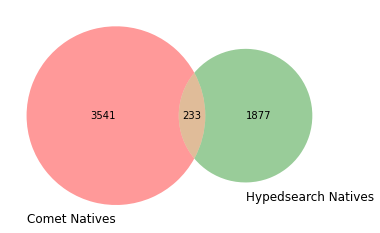

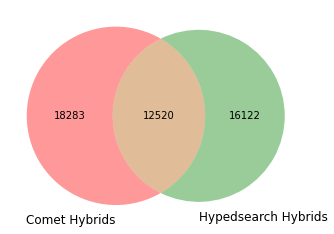

In [9]:
# So now for when natives are moved to where they should be
native_venn = venn2(subsets = (len(comet_natives)+len(current_natives), len(hypedsearch_natives), len(native_intersection)), set_labels= ("Comet Natives", "Hypedsearch Natives"))
plt.show()
hybrid_venn = venn2(subsets = (len(comet_hybrids)-len(current_natives), len(hypedsearch_hybrids), len(hybrid_intersection)), set_labels= ("Comet Hybrids", "Hypedsearch Hybrids"))
plt.show()

In [17]:
def get_spectra_files(spectra_folder):
    spectra_files = []
    for (root, _, filenames) in os.walk(spectra_folder):
        for fname in filenames:
            spectra_files.append(os.path.join(root, fname))
    return spectra_files

def get_spectrum(spectra_dir):
    spectra_files = get_spectra_files(spectra_dir)
    for file in spectra_files:
        filename = os.path.basename(file)
        left_part = filename.split(".")
        

def test_better_score(seq1, seq2, tol, spectra_dir, database_file):
    spectrum = get_spectrum(spectra_dir)
    # proteins = build_proteins()
    # score = overlap_scoring(seq1, input_spectrum.mz_values, tol, False, proteins)
    # score += losing_water(seq2, input_spectrum.mz_values, tol, False, proteins)


In [18]:
# Now to look into very interesting hybrids. It turns out these are hybrids that we got lucky and Comet found while Hypedsearch didn't

    
# with open("very_interesting_hybrids.txt", 'w') as v:
#     [v.write(str(x) + "\n") for x in very_interesting_hybrids]
    
# Now let's compare these hybrids to what Hypedsearch returned. Did Hypedsearch return anything? Should this have beaten the Hypedsearch result?

HS_missed, HS_different = [], []
for hybrid, scan_num, parent in very_interesting_hybrids:
    if scan_num not in hs_hybrid_ids:
        HS_missed.append((hybrid, scan_num, parent))
    else:
        HS_different.append((hybrid, scan_num, parent))
        
print("Out of", len(very_interesting_hybrids), "total hybrids, there were", len(HS_missed), "that HS returned nothing for and", len(HS_different), "that Hypedsearch gave something else for")


# find what hypedsearch returned with this scan_number
print(HS_different[0])
HS_better, HS_worse, HS_same = [], [], []
for hybrid, scan, parent in HS_different:
    for i, comet_scan in enumerate(hybrid_ids2):
        if scan == comet_scan:
            comet_result = comet_hybrids[i]
            verdict = test_better_score(hybrid, comet_result, ppm_tol, spectra_dir, database_file)
            if verdict == 0:
                HS_better.append(((hybrid, scan), (comet_result, comet_scan)))
            elif verdict == 1:
                HS_same.append((hybrid, scan))
            else:
                HS_worse.append((hybrid, scan))
                
            # run HS_result and hybrid through the hypedsearch scoring algorithm and see which is better

Out of 2368 total hybrids, there were 1338 that HS returned nothing for and 1030 that Hypedsearch gave something else for
('GQLGLPDEENLSER', 25, 'sp|P01325|Hypedsearch_Hybrid_GQLGLPDEEN-LSERDINLA')


In [ ]:
venn = venn2(subsets = (len(HS_better), len(HS_worse), len(HS_same)), set_labels= ("Hypedsearch scored better", "Comet scored better"))
plt.show()


# How many possible hybrids for a given mass?

## Can this be respresented in O(n)?